In [16]:
import string
import re
import html
import json
import gzip
import datetime
import numpy as np

from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [2]:
import gensim
from gsdmm import MovieGroupProcess

In [3]:
import nltk

from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

# punctuation
nltk.download("punkt")

# pos tagging
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pog66\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pog66\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pog66\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pog66\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\pog66\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pog66\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
english_stop_words = set(stopwords.words('english'))

In [5]:
qfile = './Data\\querylist_cache_00_005.json.gzip'

In [6]:
with gzip.open(qfile, 'r') as fin:
    json_bytes = fin.read()
json_str = json_bytes.decode('utf-8') 
data = json.loads(json_str) 


In [7]:
results = []
datetimes = []
for tweet in data['includes']['tweets']:
    this_date = datetime.datetime.strptime(tweet['created_at'],"%Y-%m-%dT%H:%M:%S.%f%z")
    sample1 = tweet['text']
    result = sample1
    result = re.sub(r"(@\S+|http\S+|\n|\'|[“”’])", "", result)
    result = html.unescape(result)
    results.append(result)
    datetimes.append(this_date)

In [8]:
results

['1 Judges decision that Trump likely committed crimes on Jan 6 has renewed the outcry that AG Garland is shirking his duty at DOJ. Here is a thread with my take. ',
 'Lying on a Government Form is akin to lying to the FBI.',
 '👀 ',
 '       Thanks for having us on board!',
 'Hand2 and mesothelium development and disease. In which  tackles drier vertebrates! ',
 'In todays On Tech: Maybe bye forever to the $400 big-screen TV?I started out asking why high-end smartphones reached a record high of new phones.It turns out that by choice or supply chain necessity, theres been a shift to fancier gadgets and cars. ',
 'Durango mobile home park residents are at risk of displacement and fighting to purchase their park. These families and children deserve safe and affordable housing! Link to gofundme: ',
 'Denver City Council lines were just approved last night and Im already getting emails for donations for new people running in 2023.....Its going to be a wild election year for Denver.',
 'Want

In [9]:
# Initialize wordnet lemmatizer
wnl = WordNetLemmatizer()

def postag_to_argument(postag):
    if postag[0] == "V":
        return "v"
    elif postag[0] == "N":
        return "n"
    elif postag[0] == "J":
        return "a"
    elif postag[0] == "R":
        return "r"
    else:
        return "v"

def get_words(in_sentence, in_wnlemmatizer):
    # print(in_sentence)
    # Remove punctuation
    example_sentence_no_punct = in_sentence.translate(str.maketrans("", "", string.punctuation))
    # print(example_sentence_no_punct)
    # separate tokens
    word_tokens = word_tokenize(example_sentence_no_punct)
    # print(word_tokens)
    # tag Part of Speech
    postag = dict(nltk.pos_tag(word_tokens))
    # print(postag)
    # Lemmatize
    lemmas = [ wnl.lemmatize(word, pos=postag_to_argument(postag[word])) for word in word_tokens ]
    # print(lemmas)
    # remove stop words
    filtered_lemmas = [w for w in lemmas if not w.lower() in english_stop_words]
    # print(filtered_word_tokens)
    return filtered_lemmas

In [10]:
text_tokens = [ get_words(doc, wnl) for doc in results ]
text_tokens

[['1',
  'Judges',
  'decision',
  'Trump',
  'likely',
  'commit',
  'crime',
  'Jan',
  '6',
  'renew',
  'outcry',
  'AG',
  'Garland',
  'shirk',
  'duty',
  'DOJ',
  'thread',
  'take'],
 ['Lying', 'Government', 'Form', 'akin', 'lie', 'FBI'],
 ['👀'],
 ['Thanks', 'us', 'board'],
 ['Hand2',
  'mesothelium',
  'development',
  'disease',
  'tackle',
  'drier',
  'vertebrate'],
 ['today',
  'Tech',
  'Maybe',
  'bye',
  'forever',
  '400',
  'bigscreen',
  'TVI',
  'start',
  'ask',
  'highend',
  'smartphones',
  'reach',
  'record',
  'high',
  'new',
  'phonesIt',
  'turn',
  'choice',
  'supply',
  'chain',
  'necessity',
  'theres',
  'shift',
  'fancy',
  'gadget',
  'car'],
 ['Durango',
  'mobile',
  'home',
  'park',
  'resident',
  'risk',
  'displacement',
  'fighting',
  'purchase',
  'park',
  'family',
  'child',
  'deserve',
  'safe',
  'affordable',
  'housing',
  'Link',
  'gofundme'],
 ['Denver',
  'City',
  'Council',
  'line',
  'approve',
  'last',
  'night',
  'Im

In [11]:
# create dictionary of all words in all documents
dictionary = gensim.corpora.Dictionary(text_tokens)

# filter extreme cases out of dictionary
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# create variable containing length of dictionary/vocab
vocab_length = len(dictionary)

# create BOW dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in text_tokens]

# initialize GSDMM
gsdmm = MovieGroupProcess(K=10, alpha=0.1, beta=0.3, n_iters=15)

# fit GSDMM model
y = gsdmm.fit(text_tokens, vocab_length)

In stage 0: transferred 361 clusters with 10 clusters populated
In stage 1: transferred 225 clusters with 10 clusters populated
In stage 2: transferred 179 clusters with 10 clusters populated
In stage 3: transferred 167 clusters with 10 clusters populated
In stage 4: transferred 161 clusters with 10 clusters populated
In stage 5: transferred 168 clusters with 10 clusters populated
In stage 6: transferred 148 clusters with 10 clusters populated
In stage 7: transferred 154 clusters with 10 clusters populated
In stage 8: transferred 158 clusters with 10 clusters populated
In stage 9: transferred 152 clusters with 10 clusters populated
In stage 10: transferred 156 clusters with 10 clusters populated
In stage 11: transferred 157 clusters with 10 clusters populated
In stage 12: transferred 165 clusters with 10 clusters populated
In stage 13: transferred 145 clusters with 10 clusters populated
In stage 14: transferred 152 clusters with 10 clusters populated


In [12]:
# print number of documents per topic
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of text_tokens inside):', top_index)

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

# get top words in topics
top_words(gsdmm.cluster_word_distribution, top_index, 20)

Number of documents per topic : [52 48 41 40 33 45 37 57 46 52]
Most important clusters (by number of text_tokens inside): [7 9 0 1 8 5 2 3 6 4]

Cluster 7 : [('Russia', 9), ('Donald', 8), ('fight', 8), ('people', 6), ('Ukraine', 6), ('J', 6), ('Good', 6), ('day', 6), ('war', 5), ('Trump', 5), ('NEWPresident', 5), ('go', 5), ('morning', 5), ('say', 4), ('country', 4), ('1', 4), ('Election', 4), ('want', 4), ('🇺🇦', 4), ('face', 4)]

Cluster 9 : [('Trump', 15), ('talk', 10), ('Thomas', 9), ('know', 8), ('call', 7), ('January', 7), ('phone', 7), ('get', 6), ('Clarence', 6), ('think', 6), ('gap', 6), ('6', 6), ('say', 6), ('Biden', 5), ('Kyle', 5), ('House', 5), ('election', 5), ('log', 5), ('never', 5), ('President', 4)]

Cluster 0 : [('Trump', 11), ('Russian', 10), ('change', 9), ('get', 8), ('TV', 7), ('President', 7), ('state', 5), ('Biden', 5), ('photo', 5), ('birthday', 5), ('call', 4), ('regime', 4), ('US', 4), ('say', 4), ('Happy', 4), ('never', 4), ('wrong', 4), ('partner', 3), ('

In [30]:
def draw_wordcloud(topic_number, values = 20):
    # Get topic word distributions from gsdmm model
    cluster_word_distribution = gsdmm.cluster_word_distribution
    
    # Select topic you want to output as dictionary (using topic_number)
    topic_dict = sorted(cluster_word_distribution[topic_number].items(), key=lambda k: k[1], reverse=True)
    
    # Generate a word cloud image
    wc = WordCloud(background_color='#fcf2ed', 
                                width=1800,
                                height=700,
                                random_state = 123,
                                #font_path=path_to_font,
                                colormap='flag')
    
    wc.generate_from_frequencies(dict(topic_dict[:values]))

    print(topic_number, topic_dict[:5])
    
    # Print to screen
    fig, ax = plt.subplots(figsize=[10,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off");
    
    # Save to disk
    wc.to_file(f"./wc_{topic_number}.png")
    
    plt.show()

7 [('Russia', 9), ('Donald', 8), ('fight', 8), ('people', 6), ('Ukraine', 6)]


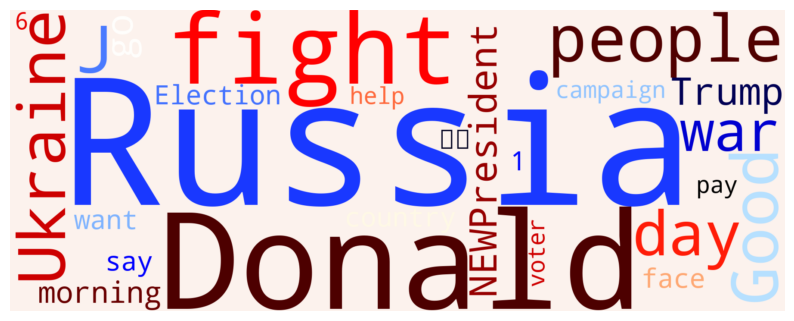

9 [('Trump', 15), ('talk', 10), ('Thomas', 9), ('know', 8), ('call', 7)]


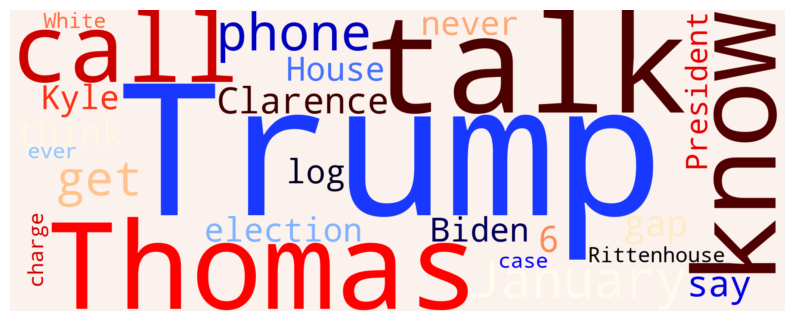

0 [('Trump', 11), ('Russian', 10), ('change', 9), ('get', 8), ('TV', 7)]


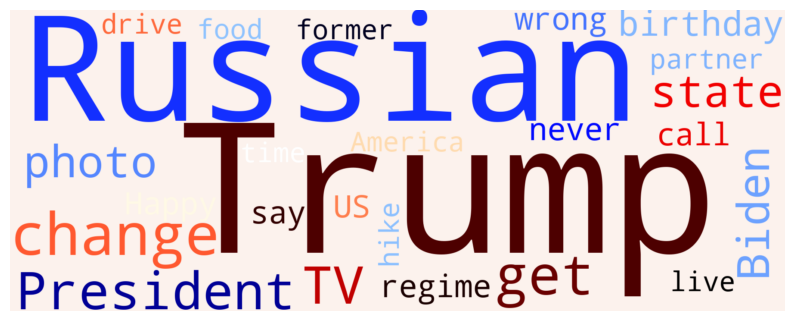

1 [('Trump', 36), ('Putin', 32), ('ask', 18), ('dirt', 18), ('Biden', 15)]


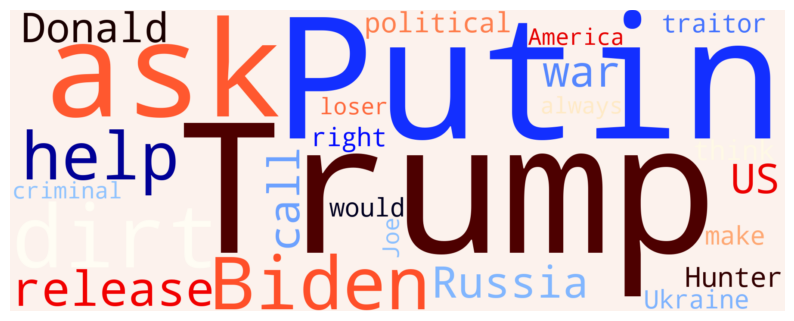

8 [('Jackson', 14), ('like', 11), ('Judge', 10), ('Ketanji', 10), ('Brown', 10)]


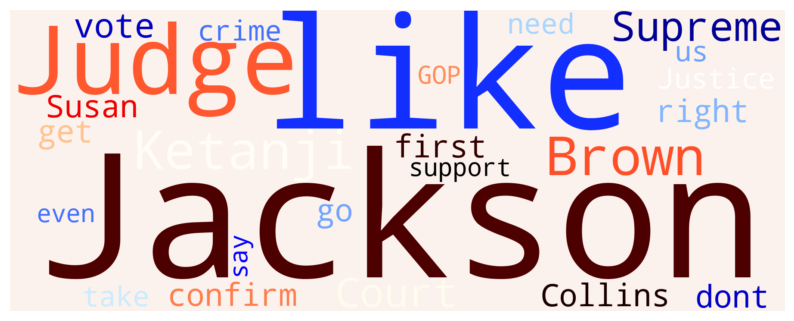

5 [('right', 6), ('Florida', 5), ('DeSantis', 5), ('try', 5), ('character', 5)]


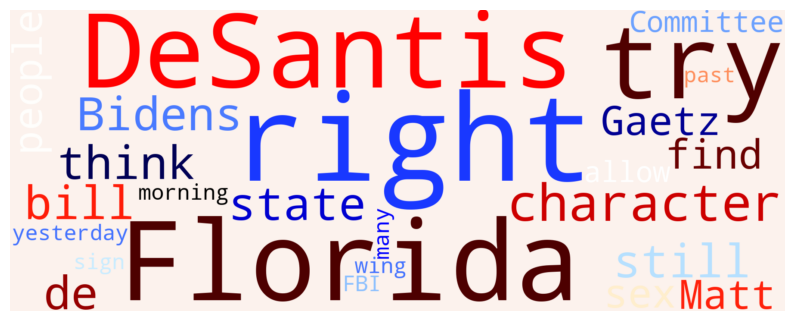

2 [('Russian', 16), ('Ukraine', 14), ('Kyiv', 12), ('Russia', 10), ('continue', 10)]


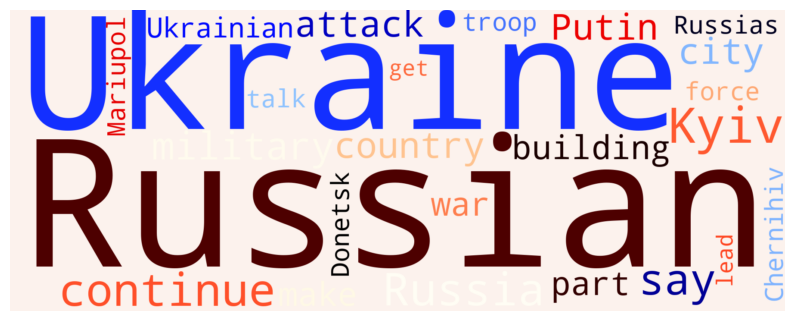

3 [('get', 7), ('test', 6), ('free', 6), ('access', 5), ('say', 5)]


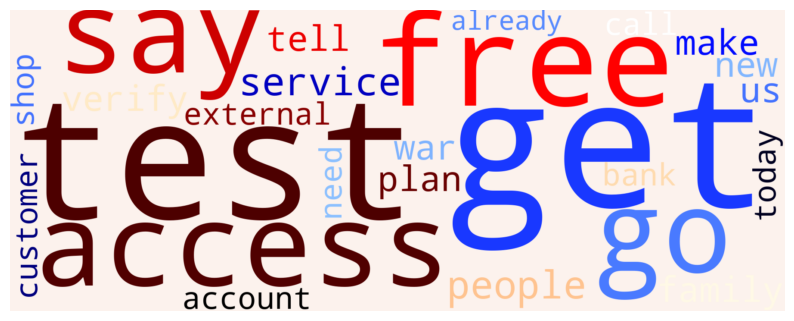

6 [('give', 6), ('time', 6), ('one', 6), ('colleague', 6), ('us', 5)]


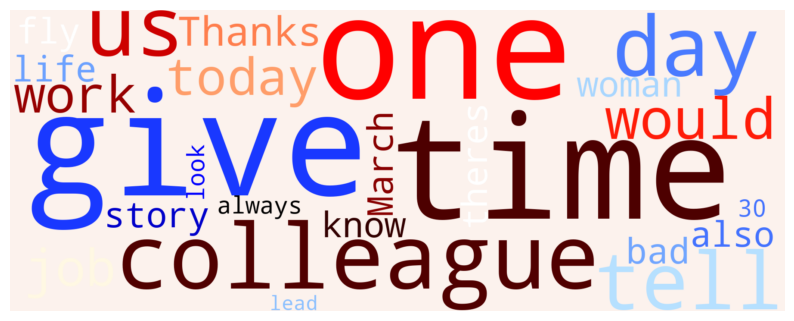

4 [('dog', 13), ('RT', 13), ('PLEASE', 12), ('Thursday', 10), ('die', 8)]


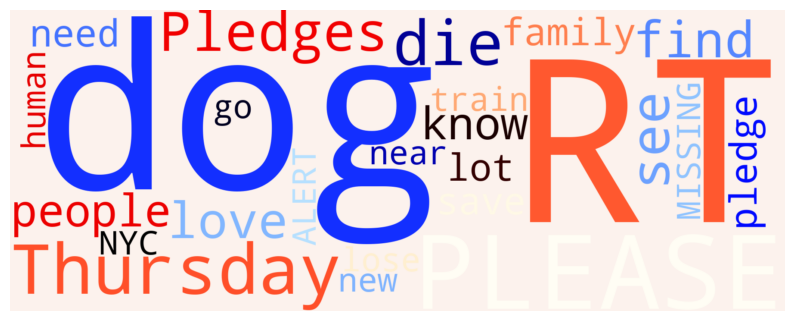

In [31]:
for cluster in top_index:
    draw_wordcloud(cluster, 25)